In [13]:
from dotenv import load_dotenv

load_dotenv()

DATA_DIR = "../data/social"

def data_file(name: str) -> str: return f"{DATA_DIR}/{name}.json"

## Data Aggregation (TikTok)

First we want to collect a set of TikTok posts to use for developing our social media post encoder. To do this, we will need to extract the `item_list` request that is used by the TikTok webapp to request video content during the infinite scroll on the For You Page. We can use inspect element to grab the URLs of these requests as we scroll on the For You Page. Then, by copying and pasting this URL into our python code, we can retrieve all the relevant metadata for the posts we are being fed by TikTok. 

This will provide us with plenty of video metadata, which we can then clean to only save the videos that have longer, more relevant metadata.

In [14]:
import json
import requests


def extract_data(data: dict) -> dict:
    extracted_data = {
        "id": data['id'],
        "description": data['desc'],
        "author": {
            "id": data['author']['id'],
            "name": data['author']['nickname'],
            "signature": data['author']['signature'],
        }
    }

    return extracted_data

def save_results(results) -> None:
    data = results['itemList']

    with open(data_file("tik_tok"), "r", encoding="utf-8") as tik_tok:
        current_data = json.load(tik_tok)

    with open(data_file("tik_tok"), "w", encoding="utf-8") as tik_tok:
        extracted_data = [extract_data(item) for item in data]
        current_data.extend(extracted_data)
        json.dump(current_data, tik_tok, indent=4)
        print(f"Added {len(extracted_data)} new results to tik_tok.json. Total results: {len(current_data)}")


def pipeline() -> None:
    url = input("Enter the url: ")
    print("Requesting data...")
    results = requests.get(url)

    if results.status_code == 200:
        save_results(results.json())

    else:
        print(f"Error: ({results.status_code}) {results.text})")

In [15]:
# pipeline()1

# Check for duplicates
with open(data_file("tik_tok"), "r", encoding="utf-8") as tik_tok:
    data = json.load(tik_tok)

    ids = [item['id'] for item in data]
    print(f"Total results: {len(ids)}")
    print(f"Unique results: {len(set(ids))}")

Total results: 108
Unique results: 107


## Data Cleaning
Now that we have the data aggregated through our pipeline, we want to create a cleaning pipeline to remove all the entries with short description and limited metadata. Let's begin by doing some EDA on our dataset.

In [16]:
import pandas as pd
import tiktoken

def load_data() -> pd.DataFrame:
    with open(data_file("tik_tok"), "r", encoding="utf-8") as tik_tok:
        data = json.load(tik_tok)

    df = pd.DataFrame(data)
    return df

def annotate_data(df: pd.DataFrame) -> pd.DataFrame:
    enc = tiktoken.encoding_for_model("gpt-3.5-turbo")

    df['description_length'] = df['description'].apply(lambda val: len(enc.encode(val)))
    df['author_signature_length'] = df['author_signature'].apply(lambda val: len(enc.encode(val)))

    return df

def overwrite_results(results) -> None:
    with open(data_file("tik_tok"), "w", encoding="utf-8") as tik_tok:
        json.dump(results, tik_tok, indent=4)
        print(f"Overwrote results in tik_tok.json. Total results: {len(results)}")

def clean_pipeline():
    data = load_data()
    df = annotate_data(data)

    start = len(df)

    # Filter out all rows with description length < 30
    df = df[df['description_length'] > 30]
    # Filter out all rows with author signature length < 20
    df = df[df['author_signature_length'] > 20]

    end = len(df)

    print(f"Filtered out {start - end} rows.")

    # Convert the dataframe back into a JSON object
    data = json.loads(df.to_json(orient="records"))
    overwrite_results(data)

In [ ]:
df = load_data()

In [ ]:
from keywords import KeywordVectorstore
openai_embeddings = KeywordVectorstore()

In [174]:
import json
import numpy as np
from functools import reduce

import torch  
import torch.nn.functional as F
from numpy.linalg import norm

from transformers import BertTokenizer,BertModel
from transformers import AutoModelForSequenceClassification, AutoTokenizer

## Experiment 1: Does segmenting the input post result in better embeddings? 

In [172]:
def post_query_term(row: pd.Series, segment=False):
    if segment: 
        return f"Author Name: {row['author_name']}. Post Description: {row['description']}. Author Description: {row['author_signature']}."
    return f"{row['author_name']} - {row['description']} - {row['author_signature']}"

In [173]:
search_terms_default = df.apply(post_query_term, axis=1).tolist()
search_terms_segmented = df.apply(post_query_term, args={"segment":True}, axis=1).tolist()

In [179]:
# returns oai keywords for post, oai keywords for segmented post, intersection between the two
def compare_segmented_input(idx):

    post, segmented_post = search_terms_default[idx], search_terms_segmented[idx]
    post_keywords, segmented_post_keywords = openai_embeddings.get_keywords([post, segmented_post])
    post_keywords, segmented_post_keywords = set([p[0] for p in post_keywords]), set([p[0] for p in segmented_post_keywords])
    return post_keywords, segmented_post_keywords, post_keywords.intersection(segmented_post_keywords)


#calculate the average overlap between keywords for normal post and segmented post. 
def test_compare_segmented_input(num_cases):
    overlaps = []
    for idx in range(num_cases): 
        _,_, overlap = compare_segmented_input(idx)
        overlaps.append(len(overlap))
    return np.mean(overlaps)

# test_compare_segmented_input(20)

2.55

### Conclusion 
* over 20 cases, an average of 2.6/3 keywords found for segmented post are also found for non segmented post.  
* segmenting the posts does not lead to different classification results.

## Experiment 2: Does BERT provide comparable embeddings? 

In [180]:
class BertEmbeddings: 
    def __init__(self) -> None:
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased') 
        self.model = BertModel.from_pretrained("bert-base-uncased")
        self.vs = self.build_vector_store()
    
    def embed(self, s, normalize_embedding = False, return_list = True):
        inputs = self.tokenizer(s, padding=True, truncation=True, max_length=512, return_tensors="pt")
        with torch.no_grad(): 
            output = self.model(**inputs)
        pool_embedding, last_hidden = output.pooler_output, output.last_hidden_state

        if return_list: 
            pool_embedding = pool_embedding.squeeze(0).tolist()
            # if normalize_embedding: 
            #     pool_embedding = self.normalize(pool_embedding)
    
        return pool_embedding

    def build_vector_store(self, as_df = True):
        # Creating embeddings for all keywords in the keywords list.

        with open('../data/keywords.json', 'r') as file: 
            keywords = json.load(file)

        keywords = reduce(lambda l1, l2: l1 + l2, keywords.values())
        vs = {i: {'text': v, 'embedding': self.embed(v)} for i, v in enumerate(keywords)}
        
        if as_df: 
            vs = pd.DataFrame.from_dict(vs, orient='index')

        return vs 
    
    def search_vector_store(self, sentence, k = 5):
        sent_embedding = self.embed(sentence)
        sent_embedding_normalized = norm(sent_embedding)
        vs = self.vs 
        vs["score"] = vs.embedding.apply(lambda x: np.dot(sent_embedding,x)/(sent_embedding_normalized*norm(x)))
  
        vs.sort_values(by="score", ascending=False, inplace=True)
        top_keywords = [
            (row["text"], row["score"])
            for index, row in vs[["text", "score"]].head(k).iterrows()
        ]
        return top_keywords


In [181]:
bert_embeddings = BertEmbeddings()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


0.0

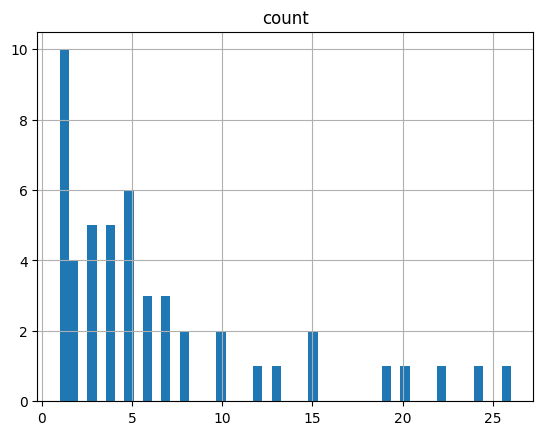

In [185]:
# compare openai embeddings with bert embeddings
def compare_oai_bert(post): 
    oai = openai_embeddings.get_keywords([post])[0]
    bert = bert_embeddings.search_vector_store(post)
    oai = set([pred[0] for pred in oai])
    bert = set([pred[0] for pred in bert])

    return oai, bert, oai.intersection(bert) 

def test_compare_oai_bert(num_cases):
    overlaps = []
    for idx in range(num_cases): 
        _, _, overlap = compare_oai_bert(search_terms_default[idx])
        overlaps.append(len(overlap))
    return np.mean(overlaps)

# test_compare_oai_bert(10)

### Conclusion 
* On average, 0 of 3 classes found by openAI embeddings are found by BERT embeddings. 
* The openAI embeddings out perform BERT embeddings, based on anecdotal comparisons of resultant classifications. 

## Experiment 3: Does HuggingFace multi-label classification work out of the box, or does it require fine-tuning? 


In [186]:
class BertClassifier: 
    def __init__(self) -> None:
        bert_ckpt = "distilbert-base-uncased" 
        self.keywords = self.get_keywords()

        self.tokenizer = AutoTokenizer.from_pretrained(bert_ckpt)
        self.model = AutoModelForSequenceClassification.from_pretrained(
            bert_ckpt,
            num_labels=len(self.keywords)  ,
            problem_type="multi_label_classification",  
        )
        self.model.config.id2label =  self.keywords

    def get_keywords(self):
        with open('../data/keywords.json', 'r') as file:
            keywords = json.load(file)
        keywords = reduce(lambda l1, l2: l1 + l2, keywords.values())
        keywords = {i: v for i, v in enumerate(keywords)}
        return keywords 
    
    def finetune(self, data):
        # TODO: fine tune the classifier with some data 
        pass 
    
    def classify(self, sequence, threshold=0.53):
        inputs = self.tokenizer(sequence, padding=True, truncation=True, max_length=512, return_tensors="pt")
        with torch.no_grad():
            logits = self.model(**inputs).logits
        probabilities = F.sigmoid(logits)

        label_indices = (probabilities > threshold).nonzero(as_tuple=True)[1]
        assigned_labels = [label_indices[i].item() for i in range(len(label_indices))]
        label_ids = [self.model.config.id2label[idx] for idx in assigned_labels]

        return probabilities, label_ids 

In [187]:
bert_classifier = BertClassifier()

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.weight', 'pre_classifier.

In [188]:
def evaluate_methods(post):
    bert_probabilities, bert_categories = bert_classifier.classify(post)
    relevant_keywords = '' #vs.get_keywords([post])

    print()
    print(f'''Input Post:\n<START> \n{post} \n<END>, 
Method 1) OpenAI embedding similarity: {relevant_keywords}, 
Method 2) BERT multihead classification: {bert_categories}, 
          BERT classification scores: {bert_probabilities}, 
          
          ''')
# evaluate_methods(search_terms_default[0])
# evaluate_methods(search_terms_default[1])



Input Post:
<START> 
onzpo - Replying to @patrick_sea567 Nah, that's CAP. It's like I always say, I #onzpo use #vfx to make it look like I'm using a #noeyefilter but no #ihaveeyes check the  #lore lol - I'm glad you're still around!
Smash Follow!🕹️
Business:chris@clickstalent.com 
<END>, 
Method 1) OpenAI embedding similarity: , 
Method 2) BERT multihead classification: ['Artisanal', 'Live Music', 'Exploration', 'Fitness Challenge'], 
          BERT classification scores: tensor([[0.5277, 0.5781, 0.4931, 0.5230, 0.5258, 0.4869, 0.4891, 0.5119, 0.4926,
         0.4927, 0.5279, 0.4953, 0.4789, 0.4848, 0.5216, 0.4852, 0.4677, 0.4983,
         0.5171, 0.5283, 0.5042, 0.5502, 0.5119, 0.4958, 0.4993, 0.4931, 0.5232,
         0.5018, 0.4678, 0.5101, 0.5196, 0.4828, 0.4945, 0.4950, 0.4952, 0.5045,
         0.4810, 0.4678, 0.5083, 0.4845, 0.5541, 0.4929, 0.5120, 0.4562, 0.4727,
         0.5134, 0.4990, 0.5245, 0.4586, 0.4996, 0.5507, 0.5054, 0.5133, 0.4752,
         0.4887, 0.4950, 0.5140, 0.4

### Conclusion 
* The classifier requires fine-tuning, since it does not automatically embed the input classes. 